# Sea surface temperature

This is an example of how to convert publicly available raster data to dfs2.

Data are provided in gzipped netcdf.


In [1]:
import gzip
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xarray

## Download file

In [2]:
url = "https://data.nodc.noaa.gov/ghrsst/L4/NSEABALTIC/DMI/DMI_OI/2015/001/20150101-DMI-L4UHfnd-NSEABALTIC-v01-fv01-DMI_OI.nc.gz"

! curl -O {url} -s

## Unzip file

In [3]:
filename = '20150101-DMI-L4UHfnd-NSEABALTIC-v01-fv01-DMI_OI.nc'

with gzip.open(filename + '.gz', 'rb') as f_in:
    with open(filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [4]:
ds = xarray.open_dataset(filename)
ds

<xarray.Dataset>
Dimensions:         (lat: 600, lon: 1334, time: 1)
Coordinates:
  * lon             (lon) float32 -9.99 -9.96 -9.93 ... 29.939999 29.969997 30.0
  * lat             (lat) float32 48.01 48.04 48.07 ... 65.92 65.95 65.979996
  * time            (time) datetime64[ns] 2015-01-01
Data variables:
    analysed_sst    (time, lat, lon) float32 ...
    analysis_error  (time, lat, lon) float32 ...
    mask            (time, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.0
    title:                  DMI Sea Surface Temperature analysis
    GDS_version_id:         v1.0-rev1.7
    netcdf_version_id:      netcdf-3.6.1-beta3 of Jan  9 2006 03:17:05
    DSD_entry_id:           DMI-L4UHfnd-NSEABALTIC-DMI_OI
    institution:            Center for Ocean and Ice, Danish Meteorological I...
    references:             http://ocean.dmi.dk
    contact:                jlh@dmi.dk
    creation_date:          2015-01-01T07:24:31 UTC
    product_version:        Version 1.0
   

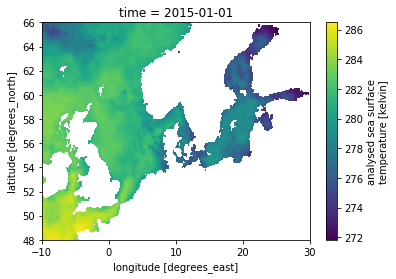

In [5]:
ds.analysed_sst[0].plot()

In [6]:
sst = ds.analysed_sst[:,:,:].values
sst.shape

(1, 600, 1334)

The input dataset dimensions are ordered (time, lon, lat).

This is the expected order

But the image have to be flipped upside down.

In [7]:
import numpy as np

sst[0] = np.flipud(sst[0])

## Coordinates

In [8]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

x0 = lon[0]
y0 = lat[0]


dx = (lon[-1] - lon[0]) / nx
dy = (lat[-1] - lat[0]) / ny

x0, y0, nx, ny, dx, dy

(-9.99, 48.01, 1334, 600, 0.029977509643005645, 0.029949995676676434)

## Time

In [9]:
import pandas as pd
t = ds.time.values
start_time = pd.to_datetime(t).to_pydatetime()[0]

## Variable types

In [10]:
from mikeio.dfs_util import type_list, unit_list

In [11]:
type_list("temperature")

{100006: 'Temperature',
 100189: 'Temperature lapse rate',
 100191: 'Temperature correction',
 100200: 'Temperature Flux'}

In [12]:
variable_type = 100006

unit_list(variable_type)

{2800: 'degree Celsius', 2801: 'degree Fahrenheit', 2802: 'degree Kelvin'}

In [13]:
unit = 2802

## Create dfs2

In [14]:
from mikeio.dfs2 import dfs2

d = []
d.append(sst)

dfsfilename = filename.replace(".nc", ".dfs2")

coordinate = ['LONG/LAT', x0, y0, 0]

dfs = dfs2()
dfs.create(filename=dfsfilename,
           data=d,
           start_time = start_time, 
           coordinate=coordinate, length_x=dx, length_y=dy,
           names=["Sea surface temperature"], 
           variable_type=[variable_type], unit=[unit]
)

# Dfs2

![dfs2](sst_dfs2.png)